# NBA Salaries Data Preparation

## D2: Final Dataset - Data Collection, Analysis, Wrangling, Feature Engineering

### By Andrej Pozderac & Andrew Edward

### Problem specification:

There are over 50 features tracked for each player’s statistics during an NBA season, as well as other features which are inherent to the player outside of a season performance such as their nationality, age, height, weight, previous salary, team they reside in, etc. All of these factors make it quite a complex challenge to simply look at players and know how they should be valued by a team in terms of compensation. We want to create a tool which can take into account all of these features and assist decision makers to make a more informed and data-driven decision on what a player’s salary should be.

### Project idea: 
The QuAM we are building is going to be running a classification task on player salaries based on a given number of inputs by a manager of a player’s statistics. We believe that there is room for fine-tuning in the decision making of a player’s salary, that is why we want this to be a classification task of a small salary range, rather than an exact number, so that the ultimate say can be on the decision maker using this helper tool. (We want the ranges to be quite narrow though, so it does not feel like it is missing the mark of a QuAM). The interface for now is going to be quite simple, input fields for a manager for each of the mandatory and optional KPIs, and after inputting the values, returning the proposed range for the player’s salary.


We start by importing some of the main libraries that we will use to handle data and visualizations

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100

#### For this project and since we are dealing with salaries and financials, we are going to be using a library called "CPI" to deal with inflation. This is to be used to handle inflation for salaries for analysing historical data, inspired from [**here**](https://medium.com/analytics-vidhya/adjusting-for-inflation-when-analysing-historical-data-with-python-9d69a8dcbc27/)


We use pip to install the library here:

In [2]:
!pip install cpi

Import the library

In [3]:
import cpi

C:\Users\Andrew\anaconda3\lib\site-packages\cpi\__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


## D2.1: Data Collection

The three main data sets we are using are as follows:
The first is about general player information: the year they played in (that season's end), their generic information - age, height, weight, and the team which they play for. This dataset will be important as we can then combine the season stats (see below) with generic information of the player we believe will be important - mainly their age, height, and weight.

The second dataset is the season stats dataset. This dataset has the season stats in great detail (about 50 features) for each player depending on the year in which they play in. We will be using this information to see which ones are most impactful for determening a high value of a salary. This data will be added to one feature from our third data set.

The third data set has the Salary information alongside some other play information, most importantly, the year which we will use to match the correct salary to the correct player in the correct season. This will be the one feature which we will add onto our second dataset and use it for finding the most important features in our data, the KPIs, as well as the main training target feature for the QuAM classifier moving forward.

The final dataset which we will construct will be made of the main defining values of the player names, as well as their  generic information as height and weight. The most important 15 KPIs selected through feature engineering, and the adjusted for inflation player salaries.

The player stat features are composed of most important basketball information regarding players, and these are focused on players game's, performance in matches, different types of performance in shots, defensive and offensive performance, in-team and between-team play such as turnovers or assists, etc. These we will not manually select, as mentioned above, but rather run them through kNN classifier to pick the strongest features.

The challneges that we forsee moving forward will be adjusting salary for inflation, connecting the datasets from different sources, based on different players and years, as well as cleaning the whole data of imporper or missing values.

## D2.2.1: Data Analysis

D2.2.2 is after picking key features from the combination of both datasets

<span style="color:#008385">

### Dataset 1: NBA Players salaries

</span>

You can find the dataset here: https://www.kaggle.com/whitefero/nba-player-salary-19902017

The dataset was published in 2017, based on data from: https://data.world/datadavis/nba-salaries/workspace/file?filename=nba_salaries_1990_to_2018.csv

This dataset contains the data about the salaries of NBA players from 1990 - 2017, the season corresponding to the salary and the team they played with.

For this project, we are going to be using the salaries from this dataset in addition to information from the other dataset we chose for our QuAM.

In [4]:
# Read the CSV file
salaries = pd.read_csv('./player_salaries/salaries_per_year.csv')
salaries.head()

,Register Value,Player Name,Salary,Season Start,Season End,Team,Full Team Name
0,1,A.C. Green,"$1,750,000.00",1990,1991,LAL,Los Angeles Lakers
1,354,A.C. Green,"$1,750,000.00",1991,1992,LAL,Los Angeles Lakers
2,727,A.C. Green,"$1,750,000.00",1992,1993,LAL,Los Angeles Lakers
3,1103,A.C. Green,"$1,885,000.00",1993,1994,PHO,Phoenix Suns
4,1497,A.C. Green,"$6,472,600.00",1994,1995,PHO,Phoenix Suns


Here, as we are using Salary data from 1990, we want to ensure that we are accounting for inflation. Lets take a look at the type of the "Salary" column.

In [5]:
salaries.dtypes

Register Value     int64
Player Name       object
Salary            object
Season Start       int64
Season End         int64
Team              object
Full Team Name    object
dtype: object

To apply changes, we need to convert the data in the column from object to float to be able to apply changes to the rows.

First we change the $XXX values into integers and then using the library [CPI] from above we are adjusting the values for inflation. This results in the correct features being picked later on as the target value of salary has now been adjusted for realm time values.

In [6]:
#Remove the $ sign and the extra decimal points
salaries['Salary'] = salaries['Salary'].str.slice(1,-1)

#Remove any ','
salaries['Salary'] = salaries['Salary'].str.replace(",","")

#Turn the column type to slaa
salaries["Salary"] = pd.to_numeric(salaries["Salary"], downcast="float")

In [7]:
salaries.dtypes

Register Value      int64
Player Name        object
Salary            float32
Season Start        int64
Season End          int64
Team               object
Full Team Name     object
dtype: object

Then, we apply our "inflate_column" function to each row

In [8]:
def inflate_column(data, column,year):
    return data.apply(lambda x: cpi.inflate(x[column], 
                      x[year]), axis=1)

salaries['Salary'] = inflate_column(salaries, 'Salary', 'Season End')
salaries

,Register Value,Player Name,Salary,Season Start,Season End,Team,Full Team Name
0,1,A.C. Green,3.226412e+06,1990,1991,LAL,Los Angeles Lakers
1,354,A.C. Green,3.132126e+06,1991,1992,LAL,Los Angeles Lakers
2,727,A.C. Green,3.041088e+06,1992,1993,LAL,Los Angeles Lakers
3,1103,A.C. Green,3.193905e+06,1993,1994,PHO,Phoenix Suns
4,1497,A.C. Green,1.066480e+07,1994,1995,PHO,Phoenix Suns
...,...,...,...,...,...,...,...
11832,6283,Zydrunas Ilgauskas,1.088629e+07,2005,2006,CLE,Cleveland Caveliers
11833,6658,Zydrunas Ilgauskas,1.143583e+07,2006,2007,CLE,Cleveland Caveliers
11834,7063,Zydrunas Ilgauskas,1.182875e+07,2007,2008,CLE,Cleveland Caveliers
11835,7485,Zydrunas Ilgauskas,1.268968e+07,2008,2009,CLE,Cleveland Caveliers


In [9]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11837 entries, 0 to 11836
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Register Value  11837 non-null  int64  
 1   Player Name     11837 non-null  object 
 2   Salary          11837 non-null  float64
 3   Season Start    11837 non-null  int64  
 4   Season End      11837 non-null  int64  
 5   Team            11837 non-null  object 
 6   Full Team Name  11837 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 647.5+ KB


In [10]:
salaries.describe()

,Register Value,Salary,Season Start,Season End
count,11837.000000,1.183700e+04,11837.000000,11837.000000
mean,5919.000000,4.171043e+06,2004.419785,2005.419785
std,3417.191903,4.955379e+06,8.168175,8.168175
min,1.000000,3.945967e+03,1990.000000,1991.000000
25%,2960.000000,1.004529e+06,1997.000000,1998.000000
50%,5919.000000,2.281852e+06,2005.000000,2006.000000
75%,8878.000000,5.325593e+06,2012.000000,2013.000000
max,11837.000000,5.105329e+07,2017.000000,2018.000000


We can see from the describe function the mean, max and min for the salaries, these will help us later as we consider and think about the ranges to apply.

After seeing the datatypes of the columns, we explore if there are any NaN objects

In [11]:
nans = np.sum(salaries.isnull())

print('Invalid enteries in the salaries file:')
print(nans)

Invalid enteries in the salaries file:
Register Value    0
Player Name       0
Salary            0
Season Start      0
Season End        0
Team              0
Full Team Name    0
dtype: int64


Since the dataset has no empty entries, we do more exploratory analysis using histograms

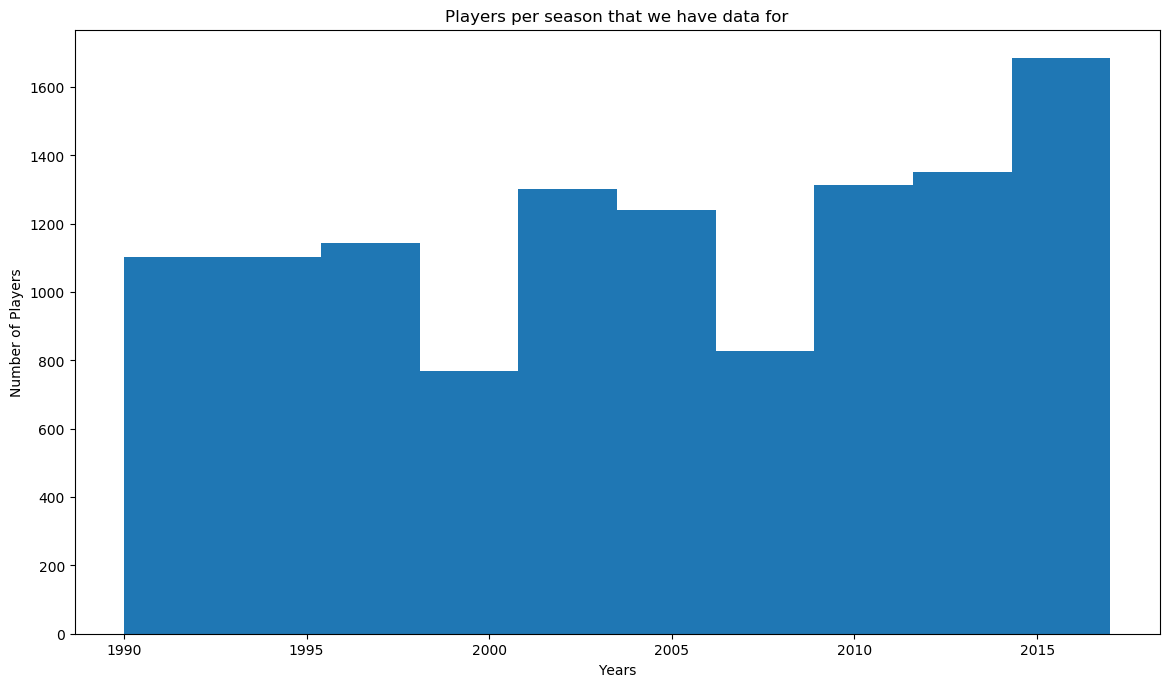

In [12]:
# plt.show()
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(14, 8))

axs.hist(x=salaries['Season Start'])
axs.set_title('Players per season that we have data for')
axs.set_xlabel('Years')
axs.set_ylabel('Number of Players')

plt.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.show()


From the head of the salaries dataset, we can see that we have salaries only starting from 1990, so we will have to keep that in mind when merging the two datasets and creating our final dataset

<span style="color:#008385">

## Dataset 2: NBA Players Stats
    
</span>

You can find the dataset here: https://www.kaggle.com/drgilermo/nba-players-stats

The dataset contains aggregate individual statistics for 67 NBA seasons. from basic box-score attributes such as points, assists, rebounds etc., to more advanced money-ball like features such as Value Over Replacement.

The data for it was scraped from: https://www.kaggle.com/drgilermo/nba-players-stats?select=Seasons_Stats.csv

The dataset is composed of 3 CSVs, we chose to cut the "player_data.csv" table since it didn't match correctly with the other two tables.

The information it held did not impact the progeress as similar information already exists in the more consistent "players.csv" file.

We first decided to match the stats data to our other target dataset (more below) of salaries in terms of years. We cut the entires before 1990 as to keep it consistent with the salaries dataset. We did this also because we saw more robust entry of stat information in the later years.

In [13]:
# Read the CSV file
players = pd.read_csv('./player_stats/players.csv')
players

,Unnamed: 0,Player,height,weight,collage,born,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky
...,...,...,...,...,...,...,...,...
3917,3917,Troy Williams,198.0,97.0,South Carolina State University,1969.0,Columbia,South Carolina
3918,3918,Kyle Wiltjer,208.0,108.0,Gonzaga University,1992.0,Portland,Oregon
3919,3919,Stephen Zimmerman,213.0,108.0,"University of Nevada, Las Vegas",1996.0,Hendersonville,Tennessee
3920,3920,Paul Zipser,203.0,97.0,NaN,1994.0,Heidelberg,Germany


From players, we only take height and weight of players as "possible features" we could use and drop the rest of the data since it does not hold much that we can use.

In [14]:
players_info = players[['Player','height','weight']]
players_info

,Player,height,weight
0,Curly Armstrong,180.0,77.0
1,Cliff Barker,188.0,83.0
2,Leo Barnhorst,193.0,86.0
3,Ed Bartels,196.0,88.0
4,Ralph Beard,178.0,79.0
...,...,...,...
3917,Troy Williams,198.0,97.0
3918,Kyle Wiltjer,208.0,108.0
3919,Stephen Zimmerman,213.0,108.0
3920,Paul Zipser,203.0,97.0


In [15]:
players_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3922 entries, 0 to 3921
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  3921 non-null   object 
 1   height  3921 non-null   float64
 2   weight  3921 non-null   float64
dtypes: float64(2), object(1)
memory usage: 92.0+ KB


In [16]:
players_info.describe()

,height,weight
count,3921.000000,3921.000000
mean,198.704922,94.783219
std,9.269761,12.039515
min,160.000000,60.000000
25%,190.000000,86.000000
50%,198.000000,95.000000
75%,206.000000,102.000000
max,231.000000,163.000000


The describe() function gives us an idea about the min and max heights and width. 

A max height of 231 exists.. For basketball, we should not be surprised :-)

In [17]:
nans = np.sum(players_info.isnull())

print('Invalid enteries in the Players file:')
print(nans)

Invalid enteries in the Players file:
Player    1
height    1
weight    1
dtype: int64


Now, after we have obsereved the players table, we will look at the rich "season stats" table

In [18]:
# Read the CSV file
seasons = pd.read_csv('./player_stats/seasons_stats.csv')
seasons

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,...,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0
24687,24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,...,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0
24688,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0


As you can see, for this table we have +24,000 rows and 53 columns. The titles for many of the columns is an abbreviation of the stat it is displaying. To understand what each column refers to, you can check this useful glossary: https://www.basketball-reference.com/about/glossary.html

In [19]:
seasons.dtypes

Unnamed: 0      int64
Year          float64
Player         object
Pos            object
Age           float64
Tm             object
G             float64
GS            float64
MP            float64
PER           float64
TS%           float64
3PAr          float64
FTr           float64
ORB%          float64
DRB%          float64
TRB%          float64
AST%          float64
STL%          float64
BLK%          float64
TOV%          float64
USG%          float64
blanl         float64
OWS           float64
DWS           float64
WS            float64
WS/48         float64
blank2        float64
OBPM          float64
DBPM          float64
BPM           float64
VORP          float64
FG            float64
FGA           float64
FG%           float64
3P            float64
3PA           float64
3P%           float64
2P            float64
2PA           float64
2P%           float64
eFG%          float64
FT            float64
FTA           float64
FT%           float64
ORB           float64
DRB       

In [20]:
seasons.describe()

,Unnamed: 0,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,24691.000000,24624.000000,24616.000000,24624.000000,18233.000000,24138.000000,24101.000000,24538.000000,18839.000000,24525.000000,...,23766.000000,20797.000000,20797.000000,24312.000000,24624.000000,20797.000000,20797.000000,19645.000000,24624.000000,24624.000000
mean,12345.000000,1992.594989,26.664405,50.837110,23.593375,1209.720317,12.479071,0.493001,0.158604,0.325455,...,0.719279,62.189210,147.199404,224.637381,114.852623,39.897052,24.470260,73.939832,116.339222,510.116350
std,7127.822084,17.429594,3.841892,26.496161,28.632387,941.146575,6.039014,0.094469,0.187495,0.218971,...,0.141824,67.324881,145.921912,228.190203,135.863913,38.713053,36.935084,67.713803,84.791873,492.922981
min,0.000000,1950.000000,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6172.500000,1981.000000,24.000000,27.000000,0.000000,340.000000,9.800000,0.458000,0.005000,0.208000,...,0.657000,12.000000,33.000000,51.000000,19.000000,9.000000,3.000000,18.000000,39.000000,106.000000
50%,12345.000000,1996.000000,26.000000,58.000000,8.000000,1053.000000,12.700000,0.506000,0.064000,0.296000,...,0.743000,38.000000,106.000000,159.000000,68.000000,29.000000,11.000000,55.000000,109.000000,364.000000
75%,18517.500000,2007.000000,29.000000,75.000000,45.000000,1971.000000,15.600000,0.544000,0.288000,0.400000,...,0.808000,91.000000,212.000000,322.000000,160.000000,60.000000,29.000000,112.000000,182.000000,778.000000
max,24690.000000,2017.000000,44.000000,88.000000,83.000000,3882.000000,129.100000,1.136000,1.000000,6.000000,...,1.000000,587.000000,1111.000000,2149.000000,1164.000000,301.000000,456.000000,464.000000,386.000000,4029.000000


Now that we took a look at some of the stats from the table, lets see if any empty entries exist!

In [21]:
nans = np.sum(seasons.isnull())

print('Invalid enteries in Seasons dataset:')
print(nans)

Invalid enteries in Seasons dataset:
Unnamed: 0        0
Year             67
Player           67
Pos              67
Age              75
Tm               67
G                67
GS             6458
MP              553
PER             590
TS%             153
3PAr           5852
FTr             166
ORB%           3899
DRB%           3899
TRB%           3120
AST%           2136
STL%           3899
BLK%           3899
TOV%           5109
USG%           5051
blanl         24691
OWS             106
DWS             106
WS              106
WS/48           590
blank2        24691
OBPM           3894
DBPM           3894
BPM            3894
VORP           3894
FG               67
FGA              67
FG%             166
3P             5764
3PA            5764
3P%            9275
2P               67
2PA              67
2P%             195
eFG%            166
FT               67
FTA              67
FT%             925
ORB            3894
DRB            3894
TRB             379
AST              67
STL

We can see that there are a lot of empty entries for some columns, which will prompt us to maybe remove them later, but first before we do that, we remove all the data from before 1991, since we only have salaries starting from that year.

In [22]:
seasons = seasons[seasons['Year'] >= 1991]

In [23]:
seasons

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
10007,10007,1991.0,Alaa Abdelnaby,PF,22.0,POR,43.0,0.0,290.0,13.1,...,0.568,27.0,62.0,89.0,12.0,4.0,12.0,22.0,39.0,135.0
10008,10008,1991.0,Mahmoud Abdul-Rauf,PG,21.0,DEN,67.0,19.0,1505.0,12.2,...,0.857,34.0,87.0,121.0,206.0,55.0,4.0,110.0,149.0,942.0
10009,10009,1991.0,Mark Acres,C,28.0,ORL,68.0,0.0,1313.0,9.2,...,0.653,140.0,219.0,359.0,25.0,25.0,25.0,42.0,218.0,285.0
10010,10010,1991.0,Michael Adams,PG,28.0,DEN,66.0,66.0,2346.0,22.3,...,0.879,58.0,198.0,256.0,693.0,147.0,6.0,240.0,162.0,1752.0
10011,10011,1991.0,Mark Aguirre,SF,31.0,DET,78.0,13.0,2006.0,16.7,...,0.757,134.0,240.0,374.0,139.0,47.0,20.0,128.0,209.0,1104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,...,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0
24687,24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,...,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0
24688,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0


Now, starting from 1991, we have around 14,000 rows of data to work with!

## D2.3: Data Wrangling

Now that we explored the data in both datasets, we start by merging both and then cleaning the final resulting dataset

In [24]:
df_NBA = pd.merge(seasons, salaries,  how='left', left_on=['Player','Year'], right_on = ['Player Name','Season End'])

In [25]:
df_NBA

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,TOV,PF,PTS,Register Value,Player Name,Salary,Season Start,Season End,Team,Full Team Name
0,10007,1991.0,Alaa Abdelnaby,PF,22.0,POR,43.0,0.0,290.0,13.1,...,22.0,39.0,135.0,6.0,Alaa Abdelnaby,7.282472e+05,1990.0,1991.0,POR,Portland Trail Blazers
1,10008,1991.0,Mahmoud Abdul-Rauf,PG,21.0,DEN,67.0,19.0,1505.0,12.2,...,110.0,149.0,942.0,214.0,Mahmoud Abdul-Rauf,3.060482e+06,1990.0,1991.0,DEN,Denver Nuggets
2,10009,1991.0,Mark Acres,C,28.0,ORL,68.0,0.0,1313.0,9.2,...,42.0,218.0,285.0,218.0,Mark Acres,8.056810e+05,1990.0,1991.0,ORL,Orlando Magic
3,10010,1991.0,Michael Adams,PG,28.0,DEN,66.0,66.0,2346.0,22.3,...,240.0,162.0,1752.0,228.0,Michael Adams,1.521023e+06,1990.0,1991.0,DEN,Denver Nuggets
4,10011,1991.0,Mark Aguirre,SF,31.0,DET,78.0,13.0,2006.0,16.7,...,128.0,209.0,1104.0,219.0,Mark Aguirre,2.055685e+06,1990.0,1991.0,DET,Detroit Pistons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15265,24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,...,65.0,189.0,639.0,10826.0,Cody Zeller,5.448212e+06,2016.0,2017.0,CHA,Charlotte Hornets
15266,24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,...,20.0,61.0,178.0,11299.0,Tyler Zeller,8.195398e+06,2016.0,2017.0,BOS,Boston Celtic
15267,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,3.0,17.0,23.0,11255.0,Stephen Zimmerman,9.732035e+05,2016.0,2017.0,ORL,Orlando Magic
15268,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,40.0,78.0,240.0,11187.0,Paul Zipser,7.683186e+05,2016.0,2017.0,CHI,Chicago Bulls


After this merge,we make sure to drop any rows that might not have a player name and would not be useful to us

In [26]:
df_NBA.dropna(subset=['Player Name'], inplace=True)

In [27]:
nans = np.sum(df_NBA.isnull())

print('Invalid enteries in the Players file:')
print(nans)

Invalid enteries in the Players file:
Unnamed: 0            0
Year                  0
Player                0
Pos                   0
Age                   0
Tm                    0
G                     0
GS                    0
MP                    0
PER                   5
TS%                  55
3PAr                 58
FTr                  58
ORB%                  5
DRB%                  5
TRB%                  5
AST%                  5
STL%                  5
BLK%                  5
TOV%                 45
USG%                  5
blanl             12730
OWS                   0
DWS                   0
WS                    0
WS/48                 5
blank2            12730
OBPM                  0
DBPM                  0
BPM                   0
VORP                  0
FG                    0
FGA                   0
FG%                  58
3P                    0
3PA                   0
3P%                2094
2P                    0
2PA                   0
2P%                  89
eF

We can see from the last call that there are some columns that are:

- Almost empty: (blanl, blank2)
- Repeated / Unnecessary: (Unnamed: 0, Tm, Full Team Name, Season Start, Season End, Player Name, Register Value)

So we drop these columns

In [28]:
df_NBA.drop(['Unnamed: 0','blanl','blank2', 'Tm','Full Team Name','Season Start','Season End','Player Name','Register Value'], inplace=True, axis=1)

Then after that, we look at the rest of the NA entries

In [29]:
nans = np.sum(df_NBA.isnull())

print('Invalid enteries in the Players file:')
print(nans)

Invalid enteries in the Players file:
Year         0
Player       0
Pos          0
Age          0
G            0
GS           0
MP           0
PER          5
TS%         55
3PAr        58
FTr         58
ORB%         5
DRB%         5
TRB%         5
AST%         5
STL%         5
BLK%         5
TOV%        45
USG%         5
OWS          0
DWS          0
WS           0
WS/48        5
OBPM         0
DBPM         0
BPM          0
VORP         0
FG           0
FGA          0
FG%         58
3P           0
3PA          0
3P%       2094
2P           0
2PA          0
2P%         89
eFG%        58
FT           0
FTA          0
FT%        518
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
Salary       0
Team         0
dtype: int64


Most of the missing values in our dataset are coming from the 3P% feature, which we can calculate on our own. The verbose feature names here would be 3PA - 3 pointers attempted, 3P - 3 pointers scored and 3P% - percentage of scored 3 pointers.

Here we are calculating the 3P% to ensure we do not drop unecessary rows and perserve data size. Moreover, we are also doing checks on 3PA and 3P as well, to see if the calculations can be performed beforehand to avoid any arithmetic errors.

In [30]:
df_NBA[['3P', '3PA','3P%']]

,3P,3PA,3P%
0,0.0,0.0,NaN
1,24.0,100.0,0.240
2,1.0,3.0,0.333
3,167.0,564.0,0.296
4,24.0,78.0,0.308
...,...,...,...
15265,0.0,1.0,0.000
15266,0.0,1.0,0.000
15267,0.0,0.0,NaN
15268,33.0,99.0,0.333


In [31]:
indices= df_NBA[ (df_NBA['3P'] == 0) & (df_NBA['3PA'] == 0) & (df_NBA['3P%'] != 0)].index

df_NBA.drop(indices, inplace = True)

In [32]:
df_NBA

,Year,Player,Pos,Age,G,GS,MP,PER,TS%,3PAr,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,Team
1,1991.0,Mahmoud Abdul-Rauf,PG,21.0,67.0,19.0,1505.0,12.2,0.448,0.099,...,87.0,121.0,206.0,55.0,4.0,110.0,149.0,942.0,3.060482e+06,DEN
2,1991.0,Mark Acres,C,28.0,68.0,0.0,1313.0,9.2,0.551,0.014,...,219.0,359.0,25.0,25.0,25.0,42.0,218.0,285.0,8.056810e+05,ORL
3,1991.0,Michael Adams,PG,28.0,66.0,66.0,2346.0,22.3,0.530,0.397,...,198.0,256.0,693.0,147.0,6.0,240.0,162.0,1752.0,1.521023e+06,DEN
4,1991.0,Mark Aguirre,SF,31.0,78.0,13.0,2006.0,16.7,0.526,0.086,...,240.0,374.0,139.0,47.0,20.0,128.0,209.0,1104.0,2.055685e+06,DET
5,1991.0,Danny Ainge,SG,31.0,80.0,0.0,1710.0,17.0,0.574,0.352,...,160.0,205.0,285.0,63.0,13.0,100.0,195.0,890.0,1.336656e+06,POR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15264,2017.0,Thaddeus Young,PF,28.0,74.0,74.0,2237.0,14.9,0.562,0.172,...,318.0,449.0,122.0,114.0,30.0,96.0,135.0,814.0,1.449935e+07,IND
15265,2017.0,Cody Zeller,PF,24.0,62.0,58.0,1725.0,16.7,0.604,0.002,...,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0,5.448212e+06,CHA
15266,2017.0,Tyler Zeller,C,27.0,51.0,5.0,525.0,13.0,0.508,0.006,...,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0,8.195398e+06,BOS
15268,2017.0,Paul Zipser,SF,22.0,44.0,18.0,843.0,6.9,0.503,0.448,...,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0,7.683186e+05,CHI


In [33]:
df_NBA[['3P', '3PA','3P%']]

,3P,3PA,3P%
1,24.0,100.0,0.240
2,1.0,3.0,0.333
3,167.0,564.0,0.296
4,24.0,78.0,0.308
5,102.0,251.0,0.406
...,...,...,...
15264,45.0,118.0,0.381
15265,0.0,1.0,0.000
15266,0.0,1.0,0.000
15268,33.0,99.0,0.333


In [34]:
nans = np.sum(df_NBA.isnull())

print('Invalid enteries in the Players file:')
print(nans)

Invalid enteries in the Players file:
Year        0
Player      0
Pos         0
Age         0
G           0
GS          0
MP          0
PER         0
TS%         0
3PAr        0
FTr         0
ORB%        0
DRB%        0
TRB%        0
AST%        0
STL%        0
BLK%        0
TOV%        0
USG%        0
OWS         0
DWS         0
WS          0
WS/48       0
OBPM        0
DBPM        0
BPM         0
VORP        0
FG          0
FGA         0
FG%         0
3P          0
3PA         0
3P%         0
2P          0
2PA         0
2P%        31
eFG%        0
FT          0
FTA         0
FT%       249
ORB         0
DRB         0
TRB         0
AST         0
STL         0
BLK         0
TOV         0
PF          0
PTS         0
Salary      0
Team        0
dtype: int64


In [35]:
df_NBA.dropna(inplace=True)

In [36]:
nans = np.sum(df_NBA.isnull())

print('Invalid enteries in the Players file:')
print(nans)

Invalid enteries in the Players file:
Year      0
Player    0
Pos       0
Age       0
G         0
GS        0
MP        0
PER       0
TS%       0
3PAr      0
FTr       0
ORB%      0
DRB%      0
TRB%      0
AST%      0
STL%      0
BLK%      0
TOV%      0
USG%      0
OWS       0
DWS       0
WS        0
WS/48     0
OBPM      0
DBPM      0
BPM       0
VORP      0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
Salary    0
Team      0
dtype: int64


Now that the dataset is finally clean, we are going to be creating a derived column "Seasons" as a derived feature from the years we already have for players.

Next we will consolidate the seasons into a new feature - seasons played. This will serve a two-fold function. First, it will give us a new feature that may be a strong representation of performance and explanation for hgih/low salaries given to players. Second, this is going to consolidate the dataset in a way where we will then only pick the newest (latest) season in which the player has played in, to avoid potential overfitting of to the salary, and to not have too much old data in the dataset as the game and style of play has evolved significantly over time.

In [37]:
seasons_played = df_NBA['Player'].value_counts()
seasons_played = seasons_played.to_dict()
seasons_played

{'Andre Miller': 26,
 'Derek Fisher': 25,
 'Joe Johnson': 23,
 'Joe Smith': 23,
 'Chauncey Billups': 23,
 'Matt Barnes': 23,
 'Sam Cassell': 22,
 'Jason Kidd': 22,
 'Josh Smith': 22,
 'Deron Williams': 22,
 'Tim Thomas': 22,
 'Drew Gooden': 22,
 'Larry Hughes': 21,
 'Peja Stojakovic': 21,
 'Chris Webber': 21,
 'Donyell Marshall': 20,
 'Kenny Anderson': 20,
 'Kobe Bryant': 20,
 'Kevin Garnett': 20,
 'Charles Smith': 20,
 'Vince Carter': 20,
 'Marcus Thornton': 19,
 'Lance Stephenson': 19,
 'Nate Robinson': 19,
 'Kevin Willis': 19,
 'Jerry Stackhouse': 19,
 'Rashard Lewis': 19,
 'Jim Jackson': 19,
 'Al Harrington': 19,
 'Ray Allen': 19,
 'Mike Bibby': 18,
 'Richard Jefferson': 18,
 'Alonzo Gee': 18,
 'Clifford Robinson': 18,
 'Tim Hardaway': 18,
 'Mike Miller': 18,
 'Shawn Marion': 18,
 'Rod Strickland': 18,
 'Dee Brown': 18,
 'Kris Humphries': 18,
 'Caron Butler': 18,
 'Tayshaun Prince': 18,
 'Michael Finley': 18,
 'Mike James': 18,
 'Kevin Martin': 18,
 'Doug Christie': 18,
 'Damon Sto

Using a custom set_value function, we assign the count of seasons we calculated to the correct player

In [38]:
# Define a function to map the values
def set_value(row_number, assigned_value):
	return assigned_value[row_number]

# Add a new column named 'Seasons'
df_NBA['seasons'] = df_NBA['Player'].apply(set_value, args =(seasons_played, ))

# Print the DataFrame
df_NBA

,Year,Player,Pos,Age,G,GS,MP,PER,TS%,3PAr,...,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,Team,seasons
1,1991.0,Mahmoud Abdul-Rauf,PG,21.0,67.0,19.0,1505.0,12.2,0.448,0.099,...,121.0,206.0,55.0,4.0,110.0,149.0,942.0,3.060482e+06,DEN,9
2,1991.0,Mark Acres,C,28.0,68.0,0.0,1313.0,9.2,0.551,0.014,...,359.0,25.0,25.0,25.0,42.0,218.0,285.0,8.056810e+05,ORL,2
3,1991.0,Michael Adams,PG,28.0,66.0,66.0,2346.0,22.3,0.530,0.397,...,256.0,693.0,147.0,6.0,240.0,162.0,1752.0,1.521023e+06,DEN,5
4,1991.0,Mark Aguirre,SF,31.0,78.0,13.0,2006.0,16.7,0.526,0.086,...,374.0,139.0,47.0,20.0,128.0,209.0,1104.0,2.055685e+06,DET,4
5,1991.0,Danny Ainge,SG,31.0,80.0,0.0,1710.0,17.0,0.574,0.352,...,205.0,285.0,63.0,13.0,100.0,195.0,890.0,1.336656e+06,POR,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15264,2017.0,Thaddeus Young,PF,28.0,74.0,74.0,2237.0,14.9,0.562,0.172,...,449.0,122.0,114.0,30.0,96.0,135.0,814.0,1.449935e+07,IND,11
15265,2017.0,Cody Zeller,PF,24.0,62.0,58.0,1725.0,16.7,0.604,0.002,...,405.0,99.0,62.0,58.0,65.0,189.0,639.0,5.448212e+06,CHA,2
15266,2017.0,Tyler Zeller,C,27.0,51.0,5.0,525.0,13.0,0.508,0.006,...,124.0,42.0,7.0,21.0,20.0,61.0,178.0,8.195398e+06,BOS,3
15268,2017.0,Paul Zipser,SF,22.0,44.0,18.0,843.0,6.9,0.503,0.448,...,125.0,36.0,15.0,16.0,40.0,78.0,240.0,7.683186e+05,CHI,1


Now, we can remove all duplicates since we are accounting for the seasons differnces using "seasons
For each player, we are keeping their final year of play

In [39]:
df_NBA = df_NBA.sort_values('Year', ascending=True).drop_duplicates(['Player'],keep='last')

# Print the DataFrame
df_NBA

,Year,Player,Pos,Age,G,GS,MP,PER,TS%,3PAr,...,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,Team,seasons
286,1991.0,Alan Ogg,C,23.0,31.0,1.0,261.0,7.4,0.455,0.036,...,49.0,2.0,6.0,27.0,8.0,53.0,54.0,2.396763e+05,MIA,1
271,1991.0,Sidney Moncrief,SG,33.0,72.0,3.0,1096.0,11.2,0.589,0.267,...,128.0,104.0,50.0,9.0,66.0,112.0,337.0,9.402685e+05,ATL,1
270,1991.0,Paul Mokeski,C,34.0,36.0,1.0,257.0,6.6,0.434,0.153,...,67.0,9.0,8.0,3.0,7.0,58.0,57.0,1.843664e+05,GSW,1
291,1991.0,Walter Palmer,C,22.0,28.0,0.0,85.0,8.5,0.388,0.022,...,21.0,6.0,3.0,4.0,6.0,20.0,40.0,4.148243e+05,UTA,1
264,1991.0,Scott Meents,PF,27.0,13.0,0.0,53.0,9.4,0.286,0.036,...,10.0,8.0,7.0,4.0,6.0,5.0,17.0,5.530991e+05,OKC,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14799,2017.0,Rudy Gobert,C,24.0,81.0,81.0,2744.0,23.3,0.682,0.002,...,1035.0,97.0,49.0,214.0,148.0,246.0,1137.0,2.173100e+06,UTA,2
14808,2017.0,Archie Goodwin,SG,22.0,12.0,0.0,184.0,18.6,0.633,0.213,...,28.0,23.0,4.0,4.0,14.0,7.0,95.0,9.793501e+04,NOH,12
14809,2017.0,Aaron Gordon,SF,21.0,80.0,72.0,2298.0,14.4,0.530,0.309,...,405.0,150.0,64.0,40.0,89.0,172.0,1019.0,4.457600e+06,ORL,3
14811,2017.0,Marcin Gortat,C,32.0,82.0,82.0,2556.0,15.5,0.593,0.003,...,849.0,121.0,40.0,65.0,118.0,213.0,883.0,1.229310e+07,WAS,8


Also, to make the salaries more readable, we change this setting in pandas

In [40]:
pd.set_option('precision', 3)

In [41]:
df_NBA

,Year,Player,Pos,Age,G,GS,MP,PER,TS%,3PAr,...,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,Team,seasons
286,1991.0,Alan Ogg,C,23.0,31.0,1.0,261.0,7.4,0.455,0.036,...,49.0,2.0,6.0,27.0,8.0,53.0,54.0,2.397e+05,MIA,1
271,1991.0,Sidney Moncrief,SG,33.0,72.0,3.0,1096.0,11.2,0.589,0.267,...,128.0,104.0,50.0,9.0,66.0,112.0,337.0,9.403e+05,ATL,1
270,1991.0,Paul Mokeski,C,34.0,36.0,1.0,257.0,6.6,0.434,0.153,...,67.0,9.0,8.0,3.0,7.0,58.0,57.0,1.844e+05,GSW,1
291,1991.0,Walter Palmer,C,22.0,28.0,0.0,85.0,8.5,0.388,0.022,...,21.0,6.0,3.0,4.0,6.0,20.0,40.0,4.148e+05,UTA,1
264,1991.0,Scott Meents,PF,27.0,13.0,0.0,53.0,9.4,0.286,0.036,...,10.0,8.0,7.0,4.0,6.0,5.0,17.0,5.531e+05,OKC,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14799,2017.0,Rudy Gobert,C,24.0,81.0,81.0,2744.0,23.3,0.682,0.002,...,1035.0,97.0,49.0,214.0,148.0,246.0,1137.0,2.173e+06,UTA,2
14808,2017.0,Archie Goodwin,SG,22.0,12.0,0.0,184.0,18.6,0.633,0.213,...,28.0,23.0,4.0,4.0,14.0,7.0,95.0,9.794e+04,NOH,12
14809,2017.0,Aaron Gordon,SF,21.0,80.0,72.0,2298.0,14.4,0.530,0.309,...,405.0,150.0,64.0,40.0,89.0,172.0,1019.0,4.458e+06,ORL,3
14811,2017.0,Marcin Gortat,C,32.0,82.0,82.0,2556.0,15.5,0.593,0.003,...,849.0,121.0,40.0,65.0,118.0,213.0,883.0,1.229e+07,WAS,8


In [42]:
df_NBA = pd.merge(df_NBA, players_info,  how='left', left_on=['Player'], right_on = ['Player'])
df_NBA

,Year,Player,Pos,Age,G,GS,MP,PER,TS%,3PAr,...,STL,BLK,TOV,PF,PTS,Salary,Team,seasons,height,weight
0,1991.0,Alan Ogg,C,23.0,31.0,1.0,261.0,7.4,0.455,0.036,...,6.0,27.0,8.0,53.0,54.0,2.397e+05,MIA,1,218.0,108.0
1,1991.0,Sidney Moncrief,SG,33.0,72.0,3.0,1096.0,11.2,0.589,0.267,...,50.0,9.0,66.0,112.0,337.0,9.403e+05,ATL,1,190.0,81.0
2,1991.0,Paul Mokeski,C,34.0,36.0,1.0,257.0,6.6,0.434,0.153,...,8.0,3.0,7.0,58.0,57.0,1.844e+05,GSW,1,213.0,113.0
3,1991.0,Walter Palmer,C,22.0,28.0,0.0,85.0,8.5,0.388,0.022,...,3.0,4.0,6.0,20.0,40.0,4.148e+05,UTA,1,216.0,97.0
4,1991.0,Scott Meents,PF,27.0,13.0,0.0,53.0,9.4,0.286,0.036,...,7.0,4.0,6.0,5.0,17.0,5.531e+05,OKC,1,208.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2017.0,Rudy Gobert,C,24.0,81.0,81.0,2744.0,23.3,0.682,0.002,...,49.0,214.0,148.0,246.0,1137.0,2.173e+06,UTA,2,216.0,111.0
1736,2017.0,Archie Goodwin,SG,22.0,12.0,0.0,184.0,18.6,0.633,0.213,...,4.0,4.0,14.0,7.0,95.0,9.794e+04,NOH,12,196.0,90.0
1737,2017.0,Aaron Gordon,SF,21.0,80.0,72.0,2298.0,14.4,0.530,0.309,...,64.0,40.0,89.0,172.0,1019.0,4.458e+06,ORL,3,206.0,99.0
1738,2017.0,Marcin Gortat,C,32.0,82.0,82.0,2556.0,15.5,0.593,0.003,...,40.0,65.0,118.0,213.0,883.0,1.229e+07,WAS,8,211.0,108.0


After exploring the data, we also noticed that the "Pos" column (position in the basketball court) could be very useful to use. Since it is a categorical column, we use get_dummies to be able to use it in the future

In [43]:
df_NBA = pd.get_dummies(df_NBA, prefix='Position_', columns=['Pos'])
df_NBA

,Year,Player,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,Position__PF-C,Position__PF-SF,Position__PG,Position__PG-SG,Position__SF,Position__SF-PF,Position__SF-SG,Position__SG,Position__SG-PG,Position__SG-SF
0,1991.0,Alan Ogg,23.0,31.0,1.0,261.0,7.4,0.455,0.036,0.182,...,0,0,0,0,0,0,0,0,0,0
1,1991.0,Sidney Moncrief,33.0,72.0,3.0,1096.0,11.2,0.589,0.267,0.438,...,0,0,0,0,0,0,0,1,0,0
2,1991.0,Paul Mokeski,34.0,36.0,1.0,257.0,6.6,0.434,0.153,0.254,...,0,0,0,0,0,0,0,0,0,0
3,1991.0,Walter Palmer,22.0,28.0,0.0,85.0,8.5,0.388,0.022,0.333,...,0,0,0,0,0,0,0,0,0,0
4,1991.0,Scott Meents,27.0,13.0,0.0,53.0,9.4,0.286,0.036,0.143,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2017.0,Rudy Gobert,24.0,81.0,81.0,2744.0,23.3,0.682,0.002,0.763,...,0,0,0,0,0,0,0,0,0,0
1736,2017.0,Archie Goodwin,22.0,12.0,0.0,184.0,18.6,0.633,0.213,0.525,...,0,0,0,0,0,0,0,1,0,0
1737,2017.0,Aaron Gordon,21.0,80.0,72.0,2298.0,14.4,0.530,0.309,0.251,...,0,0,0,0,1,0,0,0,0,0
1738,2017.0,Marcin Gortat,32.0,82.0,82.0,2556.0,15.5,0.593,0.003,0.236,...,0,0,0,0,0,0,0,0,0,0


## D2.4: Feature Engineering

We first drop negative values for selecting Kbest since it does not accept negative values.

In [44]:
df_NBA.drop(['PER', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'], axis=1, inplace=True)

Before we start adjusting our features, we adjust our label to turn it from numeric to categorical, so we are able to do a classification task for the salaries.

In [45]:
df_NBA["Salary"] = df_NBA["Salary"].round(0)
df_NBA["Salary"]

0       2.397e+05
1       9.403e+05
2       1.844e+05
3       4.148e+05
4       5.531e+05
          ...    
1735    2.173e+06
1736    9.794e+04
1737    4.458e+06
1738    1.229e+07
1739    1.060e+06
Name: Salary, Length: 1740, dtype: float64

After rounding the salaries, since the format is in scientific notation, to make it more readable we change the unit to millions

In [46]:
df_NBA['Salary'] = df_NBA['Salary'].apply(lambda x: '%.0f' % x)
df_NBA['Salary'] = pd.to_numeric(df_NBA["Salary"], downcast="float")
df_NBA['Salary'] = df_NBA['Salary'].apply(lambda x: x / 10**6)
df_NBA['Salary'] = df_NBA["Salary"].round(2)
df_NBA['Salary']

0        0.24
1        0.94
2        0.18
3        0.41
4        0.55
        ...  
1735     2.17
1736     0.10
1737     4.46
1738    12.29
1739     1.06
Name: Salary, Length: 1740, dtype: float64

Now as we explore it more, we can see that the minmum salary is 0.010 ($10,000) and the maximum is around $31M

In [47]:
df_NBA['Salary'].describe()

count    1740.000
mean        3.275
std         4.628
min         0.010
25%         0.628
50%         1.445
75%         3.647
max        31.720
Name: Salary, dtype: float64

To analyse the distribution further more, we draw a histogram based on the salary data

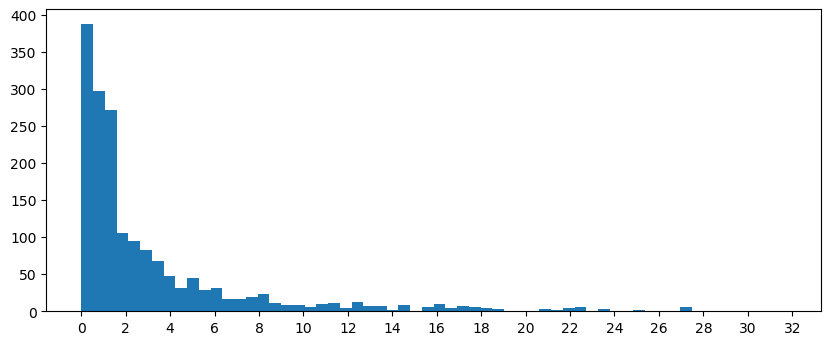

In [48]:
plt.figure(figsize = (10,4))
plt.hist(x=df_NBA['Salary'], bins = 60)
plt.xticks(np.arange(0, max(df_NBA['Salary'])+1, 2))

plt.show()

Based on the above distribution, the average salaries for basketball players and intuition, we decided to categorize the salaries in the below ranges, which show a good representation of every range as much as possible

In [49]:
df_NBA['Salary'] = pd.cut(df_NBA['Salary'],bins=[0,0.04,0.08,0.15,0.3,0.6,1,2,3,5,8,11,15,20,26,33],labels=['0 - 40k','40k - 80k','80k - 150k'
                                          ,'150k - 300k', '300k - 600k', '600k - 1M'
                                          ,'1M - 2M','2M - 3M','3M - 5M', '5M - 8M'
                                          , '8M - 11M', '11M - 15M', '15M - 20M'
                                          ,'20M - 26M', '26M - 33M'])

## Scaling:

To improve the accuracy of the data as we try to find out which features are going to be the most useful for predicting salaries, we apply scaling

We decided not to use Robust Scaler because we did not see many outliers in the data.

In [50]:
features = df_NBA.iloc[:,3:-19]

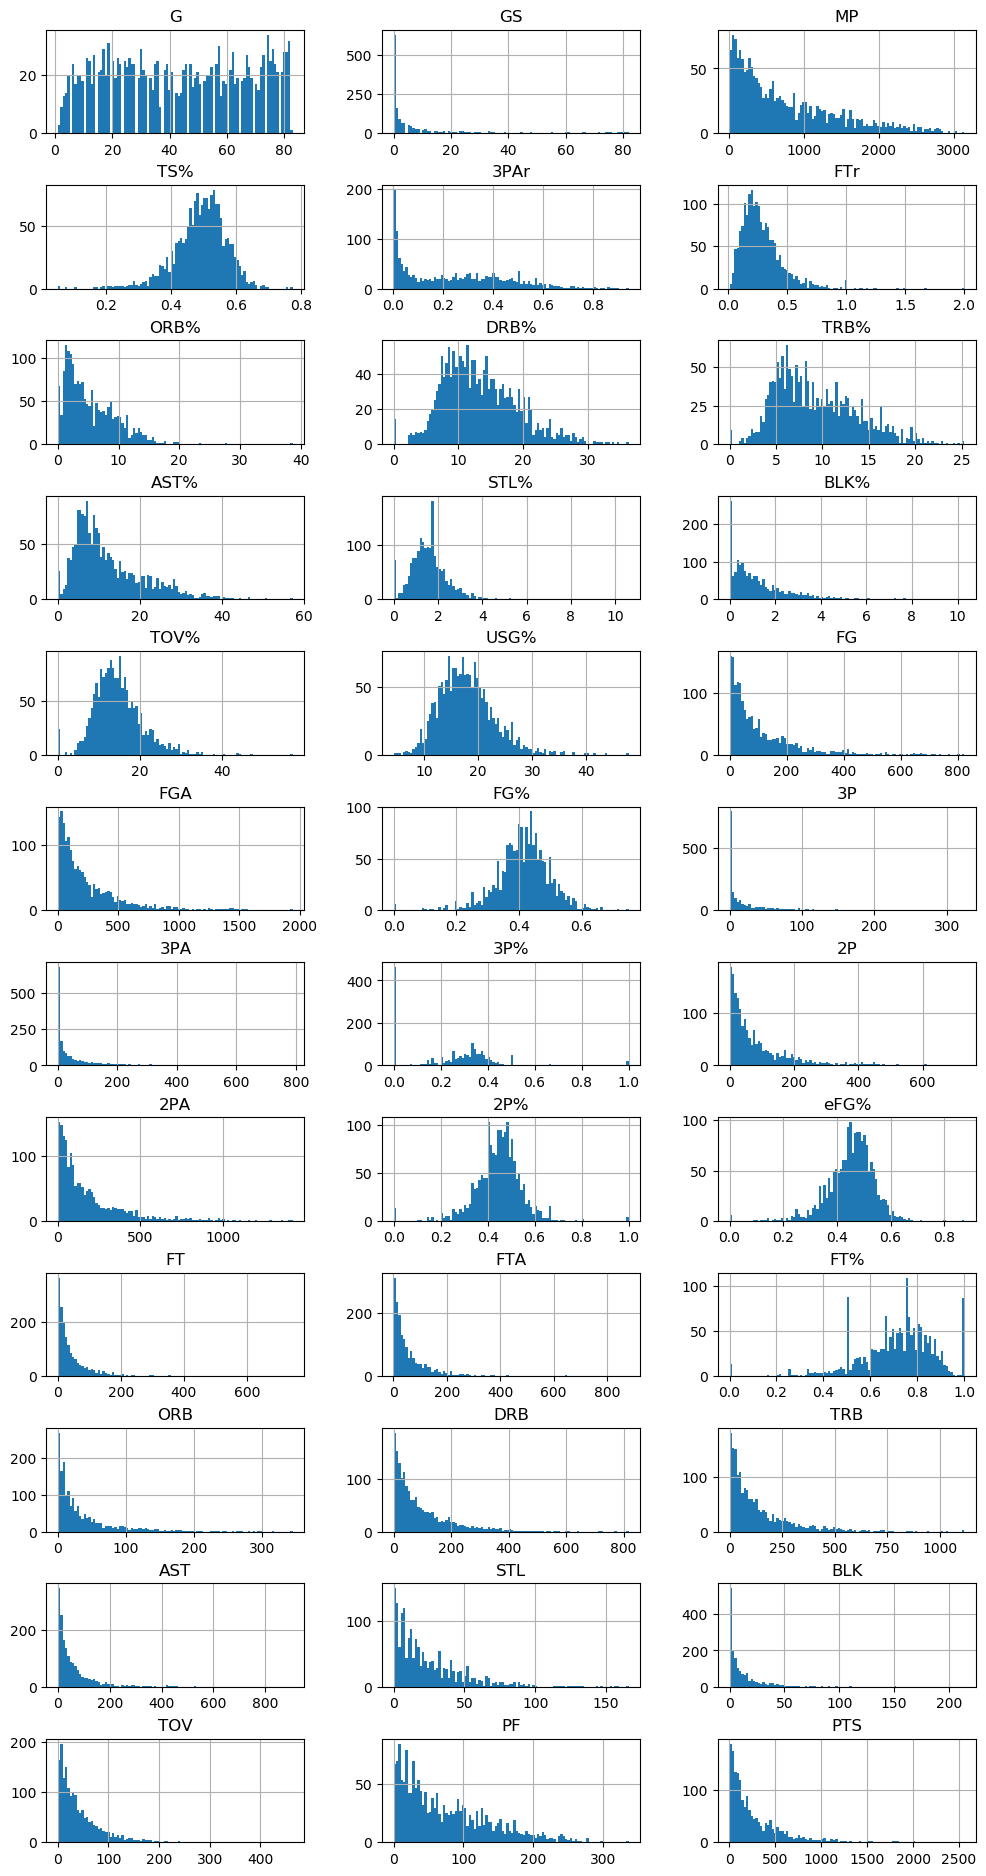

In [51]:
fig, axes = plt.subplots(len(features.columns)//3, 3, figsize=(12, 25))

i = 0
for triaxis in axes:
    for axis in triaxis:
        features.hist(column = features.columns[i], bins = 100, ax=axis)
        i = i+1
        
fig.subplots_adjust(top=0.85, hspace=0.5)

As for the choice between MinMaxScaler and StandardScaler, we saw from above that in general, our data is not normally distributed, that is why we went for MinMaxScaler to perserve the shape of our data. In case the accuracy is not entirely sufficient in D3, for one of our iterations, we could go back to this step and also make sure to scale each specific occurance with a different scaling method (for examples - GS with Robust(), 2P% with StandardScalar(), PF with MinMaxScaler).

In [52]:
from sklearn import preprocessing

# We split to by -19 to exclude any extra features we are not scaling and the target column
features = df_NBA.iloc[:,3:-19]

min_max_scaler = preprocessing.MinMaxScaler().fit(features)

X_train_minmax = min_max_scaler.transform(features)

X_train_minmax

array([[0.36585366, 0.01219512, 0.08067602, ..., 0.01724138, 0.15727003,
        0.02072741],
       [0.86585366, 0.03658537, 0.34693878, ..., 0.14224138, 0.33234421,
        0.13140399],
       [0.42682927, 0.01219512, 0.07940051, ..., 0.01508621, 0.17210682,
        0.02190066],
       ...,
       [0.96341463, 0.87804878, 0.73022959, ..., 0.19181034, 0.51038576,
        0.3981228 ],
       [0.98780488, 1.        , 0.8125    , ..., 0.25431034, 0.63204748,
        0.34493547],
       [0.45121951, 0.13414634, 0.19164541, ..., 0.06465517, 0.1958457 ,
        0.11067657]])

In [53]:
scaled_features = pd.DataFrame(X_train_minmax, columns = features.columns)
scaled_features

,G,GS,MP,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0.366,0.012,0.081,0.560,0.037,0.085,0.163,0.408,0.415,0.017,...,0.600,0.043,0.042,0.044,0.002,0.036,0.126,0.017,0.157,0.021
1,0.866,0.037,0.347,0.745,0.283,0.214,0.078,0.275,0.253,0.223,...,0.781,0.090,0.119,0.115,0.115,0.301,0.042,0.142,0.332,0.131
2,0.427,0.012,0.079,0.530,0.162,0.121,0.222,0.554,0.569,0.075,...,0.800,0.058,0.058,0.060,0.010,0.048,0.014,0.015,0.172,0.022
3,0.329,0.000,0.025,0.467,0.022,0.161,0.230,0.537,0.573,0.194,...,0.667,0.017,0.018,0.019,0.007,0.018,0.019,0.013,0.059,0.015
4,0.146,0.000,0.014,0.325,0.037,0.065,0.173,0.441,0.447,0.353,...,0.500,0.009,0.009,0.009,0.009,0.042,0.019,0.013,0.015,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,0.976,0.988,0.872,0.874,0.001,0.377,0.351,0.813,0.862,0.099,...,0.653,0.910,0.882,0.927,0.107,0.295,1.000,0.319,0.730,0.444
1736,0.134,0.000,0.056,0.806,0.226,0.258,0.106,0.328,0.320,0.363,...,0.719,0.020,0.026,0.025,0.025,0.024,0.019,0.030,0.021,0.037
1737,0.963,0.878,0.730,0.663,0.328,0.120,0.137,0.388,0.379,0.183,...,0.719,0.336,0.354,0.363,0.166,0.386,0.187,0.192,0.510,0.398
1738,0.988,1.000,0.812,0.751,0.002,0.112,0.274,0.738,0.739,0.119,...,0.648,0.690,0.748,0.761,0.134,0.241,0.304,0.254,0.632,0.345


For selecting K Best features we use the feature_selection module from Sklearn

#### Citation:
The code for this cell was inspired by this medium article and adjusted for our specific purposes and needs: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [54]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# X = df_NBA.iloc[:,3:-19]
X = scaled_features
Y = df_NBA[['Salary']]

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=25)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

   Specs    Score
1     GS  244.717
2     MP  116.681
14    FG  116.152
35   PTS  108.313
20    2P  100.029
15   FGA   99.744
21   2PA   94.858
28   DRB   90.854
24    FT   87.581
25   FTA   86.308
29   TRB   79.555
18   3PA   77.853
17    3P   72.929
30   AST   63.631
31   STL   63.062
0      G   61.461
34    PF   60.898
33   TOV   56.229
27   ORB   47.896
32   BLK   46.887


Based on the results and scores, we chose the top 15 features to use them going forward

In [55]:
best_features = pd.DataFrame(X[['GS', 'MP', 'FG', 'PTS', '2P', 'FGA', '2PA', 'DRB', 'FT', 'FTA', 'TRB', '3PA', '3P', 'AST', 'STL']])
best_features['Salary'] = df_NBA['Salary']
best_features

,GS,MP,FG,PTS,2P,FGA,2PA,DRB,FT,FTA,TRB,3PA,3P,AST,STL,Salary
0,0.012,0.081,0.029,0.021,0.033,0.027,0.037,0.042,0.008,0.010,0.044,0.001,0.000,0.002,0.036,150k - 300k
1,0.037,0.347,0.142,0.131,0.132,0.123,0.123,0.119,0.110,0.118,0.115,0.080,0.065,0.115,0.301,600k - 1M
2,0.012,0.079,0.025,0.022,0.025,0.029,0.035,0.058,0.016,0.016,0.060,0.010,0.009,0.010,0.048,150k - 300k
3,0.000,0.025,0.018,0.015,0.021,0.022,0.030,0.018,0.013,0.016,0.019,0.000,0.000,0.007,0.018,300k - 600k
4,0.000,0.014,0.008,0.006,0.008,0.013,0.018,0.009,0.003,0.003,0.009,0.000,0.003,0.009,0.042,300k - 600k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,0.988,0.872,0.501,0.444,0.566,0.321,0.438,0.882,0.417,0.540,0.927,0.000,0.000,0.107,0.295,2M - 3M
1736,0.000,0.056,0.041,0.037,0.041,0.030,0.033,0.026,0.031,0.035,0.025,0.015,0.012,0.025,0.024,80k - 150k
1737,0.878,0.730,0.477,0.398,0.433,0.445,0.420,0.354,0.209,0.245,0.363,0.338,0.238,0.166,0.386,3M - 5M
1738,1.000,0.812,0.473,0.345,0.534,0.347,0.473,0.748,0.138,0.180,0.761,0.001,0.000,0.134,0.241,11M - 15M


To look at correlations between the features and our salary target and see the current relations between the different features, we plot a correlation matrix using seaborn

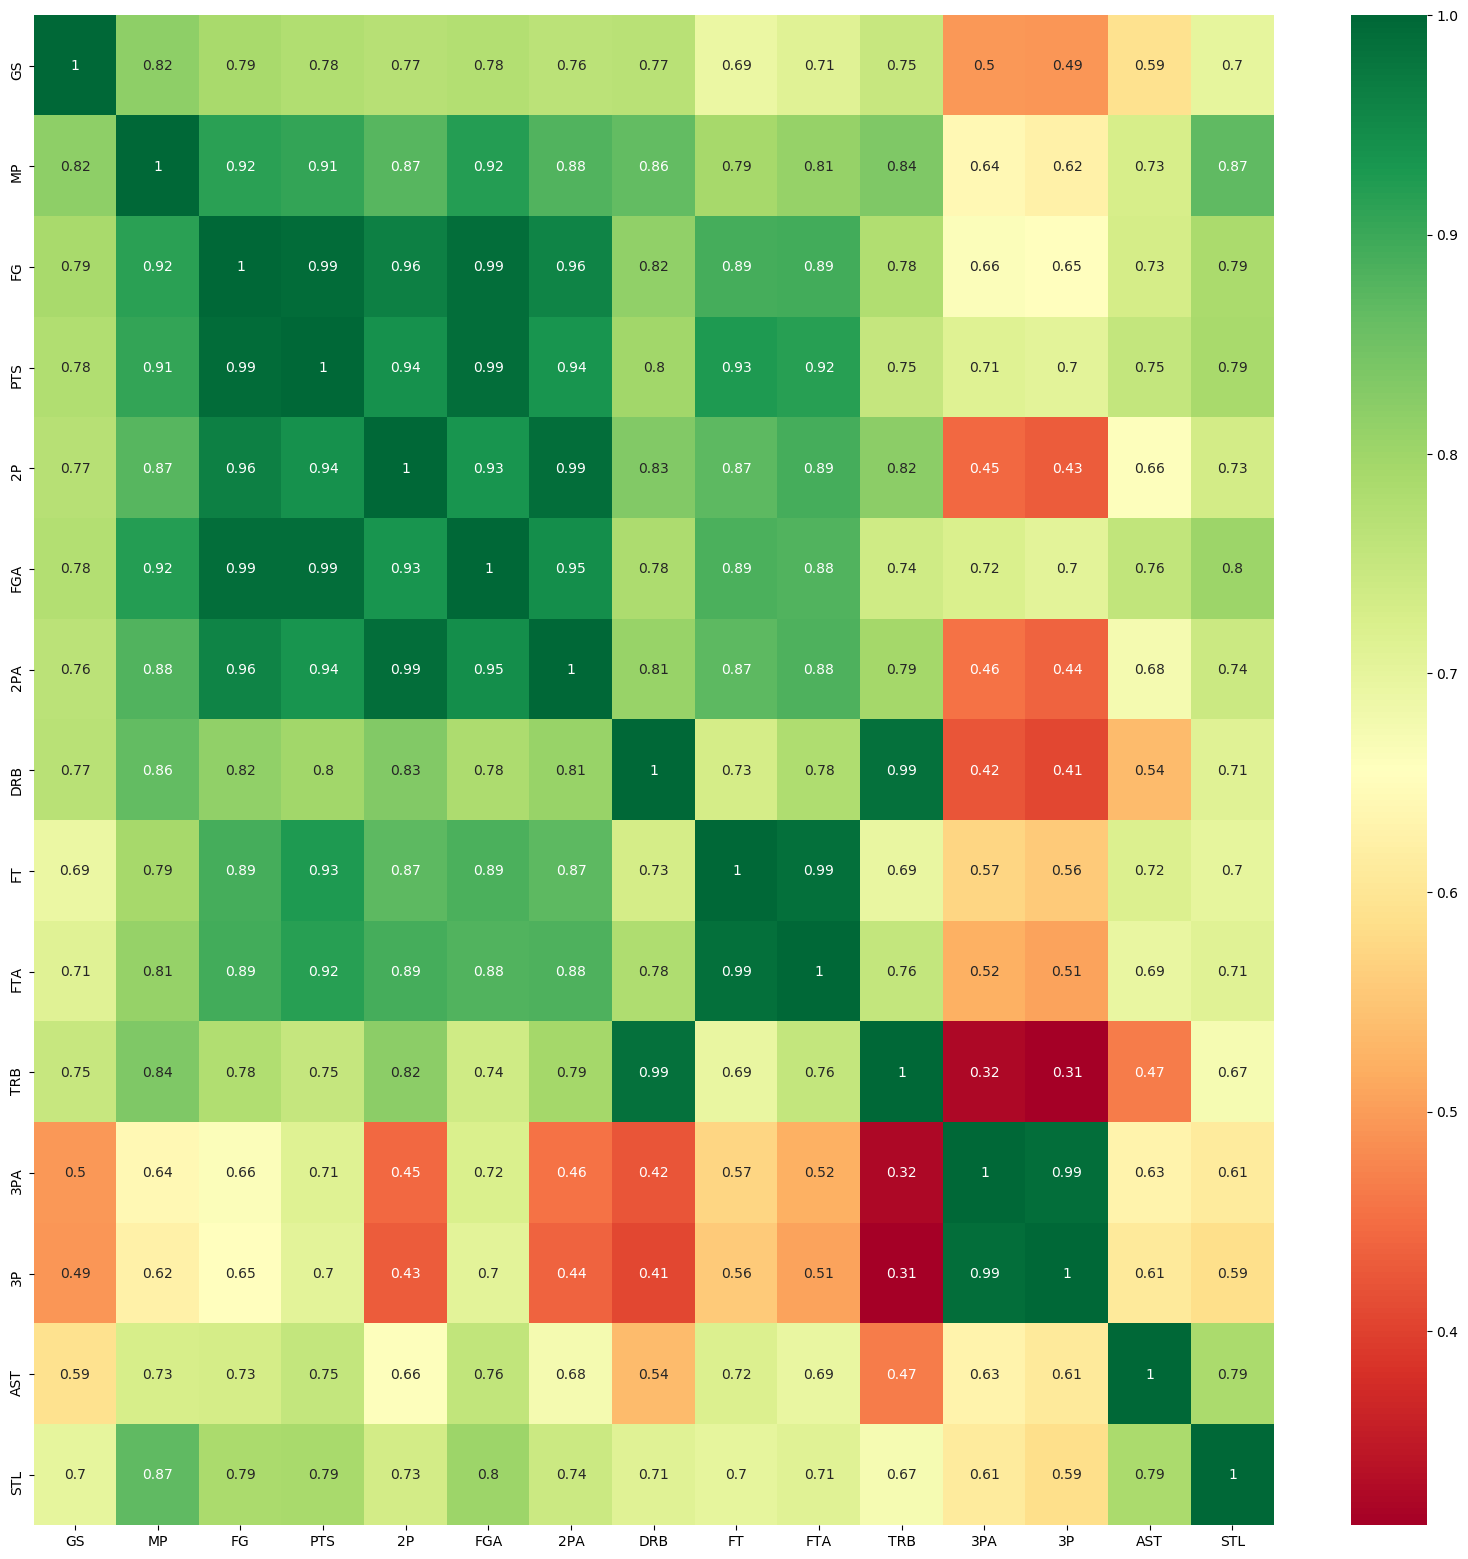

In [56]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = best_features.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(best_features[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We can see that from the correlation matrix we don't have any negative correlations. We only have low correlations between 3P (3 Pointers) and TRB (Total Rebounds) which makes sense because of the mechanics of the game where in a 3 point shooter would not be close enough to the basket to have a rebound.

Now we finalize the final dataset by adding the other features to the ones we selected

In [57]:
final_dataset = best_features.iloc[:,:-1]
final_dataset

,GS,MP,FG,PTS,2P,FGA,2PA,DRB,FT,FTA,TRB,3PA,3P,AST,STL
0,0.012,0.081,0.029,0.021,0.033,0.027,0.037,0.042,0.008,0.010,0.044,0.001,0.000,0.002,0.036
1,0.037,0.347,0.142,0.131,0.132,0.123,0.123,0.119,0.110,0.118,0.115,0.080,0.065,0.115,0.301
2,0.012,0.079,0.025,0.022,0.025,0.029,0.035,0.058,0.016,0.016,0.060,0.010,0.009,0.010,0.048
3,0.000,0.025,0.018,0.015,0.021,0.022,0.030,0.018,0.013,0.016,0.019,0.000,0.000,0.007,0.018
4,0.000,0.014,0.008,0.006,0.008,0.013,0.018,0.009,0.003,0.003,0.009,0.000,0.003,0.009,0.042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,0.988,0.872,0.501,0.444,0.566,0.321,0.438,0.882,0.417,0.540,0.927,0.000,0.000,0.107,0.295
1736,0.000,0.056,0.041,0.037,0.041,0.030,0.033,0.026,0.031,0.035,0.025,0.015,0.012,0.025,0.024
1737,0.878,0.730,0.477,0.398,0.433,0.445,0.420,0.354,0.209,0.245,0.363,0.338,0.238,0.166,0.386
1738,1.000,0.812,0.473,0.345,0.534,0.347,0.473,0.748,0.138,0.180,0.761,0.001,0.000,0.134,0.241


In [58]:
final_columns = df_NBA.iloc[:,41:]

In [59]:
final_dataset = final_dataset.merge(final_columns, left_index=True, right_index=True)
final_dataset['Salary'] = best_features['Salary']
final_dataset

,GS,MP,FG,PTS,2P,FGA,2PA,DRB,FT,FTA,...,Position__PF-SF,Position__PG,Position__PG-SG,Position__SF,Position__SF-PF,Position__SF-SG,Position__SG,Position__SG-PG,Position__SG-SF,Salary
0,0.012,0.081,0.029,0.021,0.033,0.027,0.037,0.042,0.008,0.010,...,0,0,0,0,0,0,0,0,0,150k - 300k
1,0.037,0.347,0.142,0.131,0.132,0.123,0.123,0.119,0.110,0.118,...,0,0,0,0,0,0,1,0,0,600k - 1M
2,0.012,0.079,0.025,0.022,0.025,0.029,0.035,0.058,0.016,0.016,...,0,0,0,0,0,0,0,0,0,150k - 300k
3,0.000,0.025,0.018,0.015,0.021,0.022,0.030,0.018,0.013,0.016,...,0,0,0,0,0,0,0,0,0,300k - 600k
4,0.000,0.014,0.008,0.006,0.008,0.013,0.018,0.009,0.003,0.003,...,0,0,0,0,0,0,0,0,0,300k - 600k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,0.988,0.872,0.501,0.444,0.566,0.321,0.438,0.882,0.417,0.540,...,0,0,0,0,0,0,0,0,0,2M - 3M
1736,0.000,0.056,0.041,0.037,0.041,0.030,0.033,0.026,0.031,0.035,...,0,0,0,0,0,0,1,0,0,80k - 150k
1737,0.878,0.730,0.477,0.398,0.433,0.445,0.420,0.354,0.209,0.245,...,0,0,0,1,0,0,0,0,0,3M - 5M
1738,1.000,0.812,0.473,0.345,0.534,0.347,0.473,0.748,0.138,0.180,...,0,0,0,0,0,0,0,0,0,11M - 15M


Lastly, to use the final dataset for QuAM, we export the pandas dataframe in the format of CSV

In [60]:
# final_dataset.to_csv('NBA_dataset.csv',index=False)
# If we want to export the dataset at this point, we can uncomment the line above

# D3: QuAM Report

## Iteration 1

In our first iteration, we wanted to see how some models would perform on our data. We picked Decision Trees, Random forests, MLP and kNN.

Decision Trees we thought would have the best chance / be the simplest to have high starting accuracies with. kNN would be our base for possibly going into Bagging / AdaBoost and was the most prominent one throughout the course, so we added kNN to our list of choices. Random forests would be the next best idea after Decision Trees, so we've included them as another possibility in our first iteration of models to see how it would perform, alone and comparatively to Decision Trees. Lastly, we went for a neural network. We picked MLP as our data was not compatible to run with CNN. We are looking to work with MLP across all of the future iterations as our main / second to main model and keep updating it as we go.

Our current plan was to go over each of the models, and look into the accuriacies, matrices and f1 scores to determine their performance. However, we kept going back to D2 and changing how we are presenting our categories and features to make sure all of the model choices would work, so for now the only score we are looking at for the models is accuracy.

We chose to try SVC, Decision Tree, Random Forest, MLP

In [61]:
new_dataset = final_dataset.copy()
new_dataset

,GS,MP,FG,PTS,2P,FGA,2PA,DRB,FT,FTA,...,Position__PF-SF,Position__PG,Position__PG-SG,Position__SF,Position__SF-PF,Position__SF-SG,Position__SG,Position__SG-PG,Position__SG-SF,Salary
0,0.012,0.081,0.029,0.021,0.033,0.027,0.037,0.042,0.008,0.010,...,0,0,0,0,0,0,0,0,0,150k - 300k
1,0.037,0.347,0.142,0.131,0.132,0.123,0.123,0.119,0.110,0.118,...,0,0,0,0,0,0,1,0,0,600k - 1M
2,0.012,0.079,0.025,0.022,0.025,0.029,0.035,0.058,0.016,0.016,...,0,0,0,0,0,0,0,0,0,150k - 300k
3,0.000,0.025,0.018,0.015,0.021,0.022,0.030,0.018,0.013,0.016,...,0,0,0,0,0,0,0,0,0,300k - 600k
4,0.000,0.014,0.008,0.006,0.008,0.013,0.018,0.009,0.003,0.003,...,0,0,0,0,0,0,0,0,0,300k - 600k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,0.988,0.872,0.501,0.444,0.566,0.321,0.438,0.882,0.417,0.540,...,0,0,0,0,0,0,0,0,0,2M - 3M
1736,0.000,0.056,0.041,0.037,0.041,0.030,0.033,0.026,0.031,0.035,...,0,0,0,0,0,0,1,0,0,80k - 150k
1737,0.878,0.730,0.477,0.398,0.433,0.445,0.420,0.354,0.209,0.245,...,0,0,0,1,0,0,0,0,0,3M - 5M
1738,1.000,0.812,0.473,0.345,0.534,0.347,0.473,0.748,0.138,0.180,...,0,0,0,0,0,0,0,0,0,11M - 15M


In [62]:
final_dataset = pd.get_dummies(final_dataset, columns=['Salary'])
final_dataset

,GS,MP,FG,PTS,2P,FGA,2PA,DRB,FT,FTA,...,Salary_600k - 1M,Salary_1M - 2M,Salary_2M - 3M,Salary_3M - 5M,Salary_5M - 8M,Salary_8M - 11M,Salary_11M - 15M,Salary_15M - 20M,Salary_20M - 26M,Salary_26M - 33M
0,0.012,0.081,0.029,0.021,0.033,0.027,0.037,0.042,0.008,0.010,...,0,0,0,0,0,0,0,0,0,0
1,0.037,0.347,0.142,0.131,0.132,0.123,0.123,0.119,0.110,0.118,...,1,0,0,0,0,0,0,0,0,0
2,0.012,0.079,0.025,0.022,0.025,0.029,0.035,0.058,0.016,0.016,...,0,0,0,0,0,0,0,0,0,0
3,0.000,0.025,0.018,0.015,0.021,0.022,0.030,0.018,0.013,0.016,...,0,0,0,0,0,0,0,0,0,0
4,0.000,0.014,0.008,0.006,0.008,0.013,0.018,0.009,0.003,0.003,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,0.988,0.872,0.501,0.444,0.566,0.321,0.438,0.882,0.417,0.540,...,0,0,1,0,0,0,0,0,0,0
1736,0.000,0.056,0.041,0.037,0.041,0.030,0.033,0.026,0.031,0.035,...,0,0,0,0,0,0,0,0,0,0
1737,0.878,0.730,0.477,0.398,0.433,0.445,0.420,0.354,0.209,0.245,...,0,0,0,1,0,0,0,0,0,0
1738,1.000,0.812,0.473,0.345,0.534,0.347,0.473,0.748,0.138,0.180,...,0,0,0,0,0,0,1,0,0,0


In [63]:
features = final_dataset.iloc[:,:-15].values
targets = final_dataset.iloc[:,-15:].values

In [64]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics

features_train, features_test, targets_train, targets_test = train_test_split(features, targets,  
                                            test_size=0.20, shuffle=False,
                                            random_state=99)

In [65]:
features_1 = new_dataset.iloc[:,:-1]
targets_1 = new_dataset['Salary']

In [66]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics

features_train_1, features_test_1, targets_train_1, targets_test_1 = train_test_split(features_1, targets_1,  
                                            test_size=0.20, shuffle=False,
                                            random_state=99)

### K-NN

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

classifier = KNeighborsClassifier(n_neighbors=10, weights='uniform')

cv_results = cross_validate(classifier, features_train_1, targets_train_1, cv=20, return_train_score=True)

print('Mean test score: {:.3f} (std: {:.3f})'
      '\nMean train score: {:.3f} (std: {:.3f})'.format(
                                              np.mean(cv_results['test_score']),
                                              np.std(cv_results['test_score']),
                                              np.mean(cv_results['train_score']),
                                              np.std(cv_results['train_score'])))

C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)


Mean test score: 0.236 (std: 0.048)
Mean train score: 0.374 (std: 0.005)


In [68]:
classifier.fit(features_train_1, targets_train_1)

Y_pred = classifier.predict(features_test_1)

accuracy = metrics.accuracy_score(targets_test_1, Y_pred)

print('Accuracy of k-NN on TEST set: {:.2f}'.format(accuracy))

Accuracy of k-NN on TEST set: 0.12


### Decision Trees

In [69]:
from sklearn import tree

criterion = 'entropy'
max_depth = 12
rnd_seed = 99

decision_tree = tree.DecisionTreeClassifier(criterion=criterion, 
                                            max_depth=max_depth, 
                                            random_state=rnd_seed)

dt_classifier = decision_tree.fit(features_1, targets_1)

Y_pred = dt_classifier.predict(features_test_1)
accuracy_test = metrics.accuracy_score(targets_test_1, Y_pred)

Y_pred = dt_classifier.predict(features_train_1)
accuracy_train = metrics.accuracy_score(targets_train_1, Y_pred)

print(' Accuracy: {:.2f} ({:.2f})'.format(accuracy_test, accuracy_train))

 Accuracy: 0.90 (0.88)


### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
max_depth = 20

n_estimators = 200

random_forest_clf = RandomForestClassifier(max_depth=max_depth, 
                                           n_estimators=n_estimators,
                                           random_state=99)

random_forest_clf.fit(features_train_1, targets_train_1)

Y_pred = random_forest_clf.predict(features_test_1)

accuracy = metrics.accuracy_score(targets_test_1, Y_pred)

print('Accuracy random forest ({} DTs): {:.2f}'.format(n_estimators, accuracy))

Accuracy random forest (200 DTs): 0.20


### MLP

In [72]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils

Using TensorFlow backend.
C:\Users\Andrew\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Andrew\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Andrew\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Andrew\anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [73]:
MLP_model = Sequential()

MLP_model.add(Dense(12, input_dim=32, use_bias=True, 
                    activation='relu'))

MLP_model.add(Dense(8, use_bias=True, 
                    activation='relu')) 

MLP_model.add(Dense(15, use_bias=True, 
                    activation='sigmoid'))  
MLP_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                396       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                135       
Total params: 635
Trainable params: 635
Non-trainable params: 0
_________________________________________________________________


In [74]:
MLP_model.compile(loss='binary_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [75]:
learning_evolution = MLP_model.fit(features_train, targets_train, epochs=150, 
                                   batch_size=10, #shuffle=True,
                                   validation_split=0.25)


Train on 1044 samples, validate on 348 samples
Epoch 1/150
1044/1044 [==============================] - 0s 296us/step - loss: 1.4145 - accuracy: 0.5306 - val_loss: 0.6317 - val_accuracy: 0.6966
Epoch 2/150
1044/1044 [==============================] - 0s 139us/step - loss: 0.5226 - accuracy: 0.8065 - val_loss: 0.4447 - val_accuracy: 0.8678
Epoch 3/150
1044/1044 [==============================] - 0s 129us/step - loss: 0.4036 - accuracy: 0.8671 - val_loss: 0.3533 - val_accuracy: 0.8690
Epoch 4/150
1044/1044 [==============================] - 0s 139us/step - loss: 0.3191 - accuracy: 0.8711 - val_loss: 0.2806 - val_accuracy: 0.9176
Epoch 5/150
1044/1044 [==============================] - 0s 142us/step - loss: 0.2581 - accuracy: 0.9331 - val_loss: 0.2399 - val_accuracy: 0.9333
Epoch 6/150
1044/1044 [==============================] - 0s 130us/step - loss: 0.2277 - accuracy: 0.9333 - val_loss: 0.2273 - val_accuracy: 0.9333
Epoch 7/150
1044/1044 [==============================] - 0s 144us/step

Epoch 55/150
1044/1044 [==============================] - 0s 127us/step - loss: 0.2036 - accuracy: 0.9333 - val_loss: 0.2307 - val_accuracy: 0.9333
Epoch 56/150
1044/1044 [==============================] - 0s 116us/step - loss: 0.2029 - accuracy: 0.9333 - val_loss: 0.2256 - val_accuracy: 0.9337
Epoch 57/150
1044/1044 [==============================] - 0s 125us/step - loss: 0.2029 - accuracy: 0.9333 - val_loss: 0.2242 - val_accuracy: 0.9333
Epoch 58/150
1044/1044 [==============================] - 0s 122us/step - loss: 0.2028 - accuracy: 0.9334 - val_loss: 0.2256 - val_accuracy: 0.9337
Epoch 59/150
1044/1044 [==============================] - 0s 123us/step - loss: 0.2025 - accuracy: 0.9333 - val_loss: 0.2264 - val_accuracy: 0.9337
Epoch 60/150
1044/1044 [==============================] - 0s 120us/step - loss: 0.2016 - accuracy: 0.9332 - val_loss: 0.2331 - val_accuracy: 0.9326
Epoch 61/150
1044/1044 [==============================] - 0s 136us/step - loss: 0.2010 - accuracy: 0.9332 - val_

1044/1044 [==============================] - 0s 124us/step - loss: 0.1907 - accuracy: 0.9335 - val_loss: 0.2170 - val_accuracy: 0.9322
Epoch 111/150
1044/1044 [==============================] - 0s 115us/step - loss: 0.1902 - accuracy: 0.9328 - val_loss: 0.2202 - val_accuracy: 0.9297
Epoch 112/150
1044/1044 [==============================] - 0s 129us/step - loss: 0.1899 - accuracy: 0.9332 - val_loss: 0.2184 - val_accuracy: 0.9318
Epoch 113/150
1044/1044 [==============================] - 0s 122us/step - loss: 0.1898 - accuracy: 0.9336 - val_loss: 0.2206 - val_accuracy: 0.9287
Epoch 114/150
1044/1044 [==============================] - 0s 124us/step - loss: 0.1896 - accuracy: 0.9333 - val_loss: 0.2177 - val_accuracy: 0.9320
Epoch 115/150
1044/1044 [==============================] - 0s 128us/step - loss: 0.1897 - accuracy: 0.9338 - val_loss: 0.2160 - val_accuracy: 0.9335
Epoch 116/150
1044/1044 [==============================] - 0s 128us/step - loss: 0.1897 - accuracy: 0.9331 - val_loss: 0

In [76]:
loss, accuracy = MLP_model.evaluate(features_test, targets_test)
print('Accuracy: {:.2f}% - Loss {:.2f}'.format(accuracy*100, loss))

348/348 [==============================] - 0s 26us/step
Accuracy: 93.33% - Loss 0.26


### The actual QuAM and Lessons Learned:

For the QuAM we have the next plan in mind. We learned a bit about using ipwidgets and how to get inputs from the user. We want to build the QuAM to ask the inputs for all of the main features needed, while programatically looking into the given position, for example, and then selecting the correct dummy variable for positions to increase while keeping the rest as 0s, etc. We are also going to noramlize the data with the whole dataset in mind, before passing it through the model. For now the model we are currently using the best accuracy one, decision trees, for running some of our prediction tests. We will be updating the ipwidgets and the model of choice as we go through the next two iterations soon.

Some of the important lessons we learned is that we might have to keep going back to feature engineering, as we have throughout our work on D3 constantly. There are small things which we may have missed and should not be lazy to go back and fix moving forward, even though D2 should be considered finalized by now, especially for getting highest accuracies possible out of the MLP. Additionally, we saw that the models had a high variety in accuracies provided, and one thing possbily not represented in our notebook is the amount of different testings we have performed given different model attributes set. We saw a lot of discrepancies and believe we should consider other models as well moving forward with the iterations.

### QuAM

This is just to demonstrate how an example input would go through the prediction.

The input also as we finalize will first go through scaling before going to the predict function

In [77]:
x_dataset = final_dataset.copy()
x_dataset.columns

Index(['GS', 'MP', 'FG', 'PTS', '2P', 'FGA', '2PA', 'DRB', 'FT', 'FTA', 'TRB',
       '3PA', '3P', 'AST', 'STL', 'seasons', 'height', 'weight', 'Position__C',
       'Position__C-PF', 'Position__C-SF', 'Position__PF', 'Position__PF-C',
       'Position__PF-SF', 'Position__PG', 'Position__PG-SG', 'Position__SF',
       'Position__SF-PF', 'Position__SF-SG', 'Position__SG', 'Position__SG-PG',
       'Position__SG-SF', 'Salary_0 - 40k', 'Salary_40k - 80k',
       'Salary_80k - 150k', 'Salary_150k - 300k', 'Salary_300k - 600k',
       'Salary_600k - 1M', 'Salary_1M - 2M', 'Salary_2M - 3M',
       'Salary_3M - 5M', 'Salary_5M - 8M', 'Salary_8M - 11M',
       'Salary_11M - 15M', 'Salary_15M - 20M', 'Salary_20M - 26M',
       'Salary_26M - 33M'],
      dtype='object')

In [78]:
new_input = [60, 1800, 60, 50, 40, 100, 500, 120, 40, 80, 60, 600, 38, 150, 130, 4, 180.0, 73.2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
new_input = pd.Series(new_input)

In [79]:
new_input = np.array([new_input])
new_output = dt_classifier.predict(new_input)

In [80]:
new_output

array(['5M - 8M'], dtype=object)

In [81]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from ipywidgets import Layout

In [86]:
def on_button_clicked(b):
    output_list = [
              GS.value,
              MP.value,
              FG.value,
              PTS.value,
              P2.value,
              FGA.value,
              PA2.value,
              DRB.value,
              FT.value,
              FTA.value,
              TRB.value,
              PA3.value,
              P3.value,
              AST.value,
              STL.value,
              seasons.value,
              height.value,
              weight.value,
              position.value,
             ]
    
    selected_position = "Position__" + output_list[len(output_list)-1]
    output_list.pop()
    positions_list = final_dataset.columns.to_list()[18:32]
    
    positions_output = []
    
    for i in range(0,len(positions_list)):
        if selected_position == positions_list[i]:
            positions_output.append(1)
        else:
            positions_output.append(0)
            
    #append positions
    output_list.extend(positions_output)
    
#     scaled_output = min_max_scaler.transform(output_list)

#     scaled_output
    
    output_list = pd.Series(output_list)
    output_list = np.array([output_list])
    
    result = dt_classifier.predict(output_list)
#     #output result
    with output:
        clear_output()
#         print(scaled_output)
        print("------------------------------------")
        print("The salary for this player should be in the range of:")
        print(result)

In [83]:
# 1. Position
position = widgets.Combobox(
                            placeholder='Choose position',
                            options=['C',
                                     'C-PF', 
                                     'C-SF', 
                                     'PF', 
                                     'PF-C',
                                     'PF-SF',
                                     'PG',
                                     'PG-SG',
                                     'SF',
                                     'SF-PF',
                                     'SF-SG',
                                     'SG',
                                     'SG-PG',
                                     'SG-SF'
                                    ],
                            description='',
                            ensure_option=True,
                            disabled=False
)


# 2. Games Started
GS = widgets.IntText(
                    min=0,
                    step=1,
                    description='',
                    disabled=False,
                    display='flex')

# 3. Minutes Played
MP = widgets.IntText(
                            min=0,
                            step=1,
                            description='',
                            disabled=False,
                            display='flex')

# 4. Field Goals
FG = widgets.IntText(
                            min=0,
                            step=1,
                            description='',
                            disabled=False,
                            display='flex')

# 5. Points
PTS = widgets.IntText(
                            min=0,
                            step=1,
                            description='',
                            disabled=False,
                            display='flex')

# 6. 2-Point Field Goals 
P2 = widgets.IntText(
                            min=0,
                            step=1,
                            description='',
                            disabled=False,
                            display='flex')

# 7. Field Goal Attempts
FGA = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 8. 2-Point Field Goal Attempts
PA2 = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 9. Defensive Rebounds
DRB = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 10. Free Throws
FT = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 11. Free Throw Attempts
FTA = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 12. Total Rebounds
TRB = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 13. 3-Point Field Goal Attempts
PA3 = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')
# 14. 3-Point Field Goals
P3 = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 15. Assists
AST = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')
# 16. Steals
STL = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 17. Seasons
seasons = widgets.IntText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 18. Height
height = widgets.FloatText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# 19. Weight
weight = widgets.FloatText(
                             min=0,
                             step=1,
                             description='',
                             disabled=False,
                             display='flex')

# Submit button
submit = widgets.Button(
                        value=False,
                        description='Predict Salary',
                        disabled=False,
                        button_style='', # 'success', 'info', 'warning', 'danger' or ''
                        tooltip='Description',
                        icon='check' # (FontAwesome names without the `fa-` prefix)
                        )


In [87]:
# items = [widgets.Label(str(i)) for i in range(4)]
left_box = widgets.VBox([widgets.Label("NBA PLAYER QuAM:"),
                         widgets.Label("------------------------"),
                         widgets.Label("01. Position:"),
                         widgets.Label("02. Games Started:"),
                         widgets.Label("03. Minutes Played:"), 
                         widgets.Label("04. Field Goals:"),
                         widgets.Label("05. Points:"),
                         widgets.Label("06. 2-Point Field Goals"),
                         widgets.Label("07. Field Goal Attempts:"),
                         widgets.Label("08. 2-Point Field Goal Attempts:"),
                         widgets.Label("09. Defensive Rebounds:"),
                         widgets.Label("10. Free Throws:"),
                         widgets.Label("11. Free Throw Attempts:"),
                         widgets.Label("12. Total Rebounds:"),
                         widgets.Label("13. 3-Point Field Goal Attempts:"),
                         widgets.Label("14. 3-Point Field Goals:"),
                         widgets.Label("15. Assists:"),
                         widgets.Label("16. Steals:"),
                         widgets.Label("17. Seasons:"),
                         widgets.Label("18. Height:"),
                         widgets.Label("19. Weight:"),
                         widgets.Label(""),
                         submit,
                        ])

right_box = widgets.VBox([widgets.Label(""),
                          widgets.Label(""),
                          position,
                          GS,
                          MP,
                          FG,
                          PTS,
                          P2,
                          FGA,
                          PA2,
                          DRB,
                          FT,
                          FTA,
                          TRB,
                          PA3,
                          P3,
                          AST,
                          STL,
                          seasons,
                          height,
                          weight,
                         ])

form = widgets.HBox([left_box, right_box])

output = widgets.Output()

display(form, output)

submit.on_click(on_button_clicked)

Output()